Cross-validation to determine how many canonical components (or latent dimension). We want the canonical components that have an r2 value greater than the r2 value of the first canonical component of the null model. "Plot eigenvalues (r2)" helps visualize that.\
U and V are the latent variables of X and Y. A and B are the canonical weights or coefficients (tell us how each variable such as the gains/time latency) are related). Essentially X=AU, Y=BV. We can use pseudoinverse to solve and get back from the latent space to the actual X and Y space.

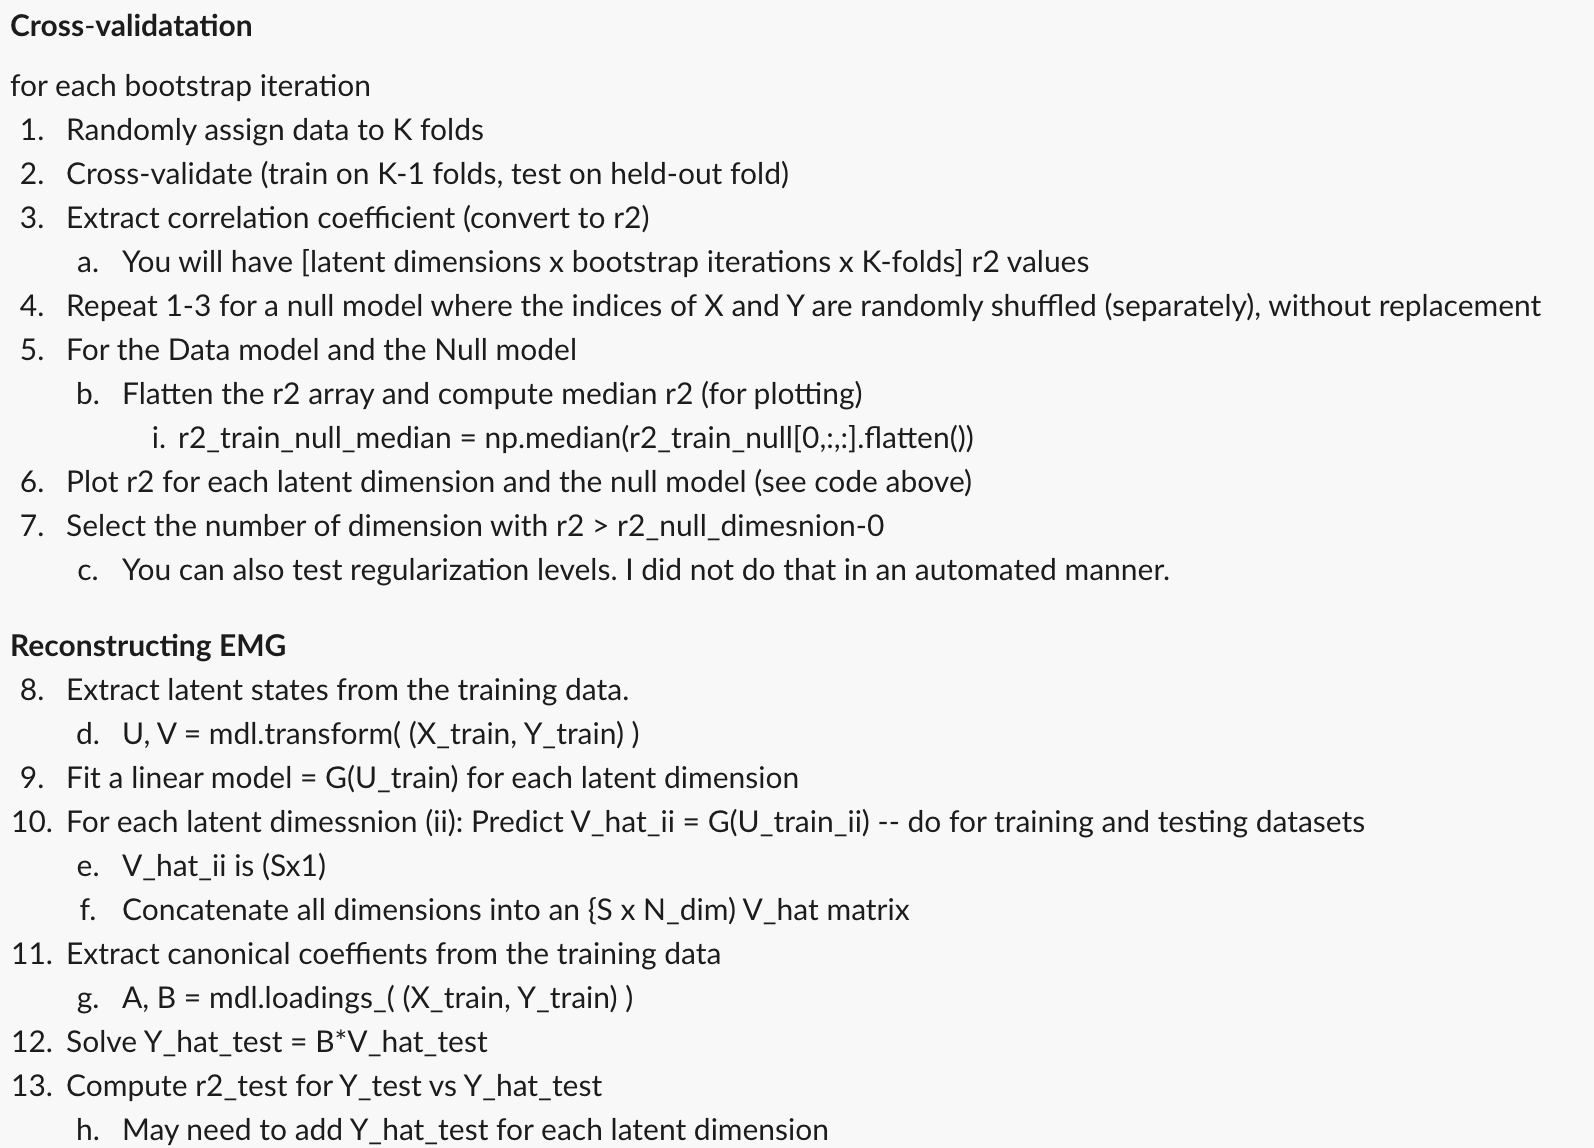

In [ ]:
!pip install cca-zoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from cca_zoo import linear as czoo
from cca_zoo import model_selection as modSelect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Model Initializing & Fitting

# Assign data
latentDim = 4

df = pd.read_excel('data.xlsx')
X = df.iloc[:, 43:47]
Y = df.iloc[:, 79:87]

# Build model
mdl = czoo.rCCA(latent_dimensions = latentDim,  c=1)

# Fit model
mdl.fit( (X, Y) )

# Extract parameters
r2 = np.square(mdl.average_pairwise_correlations( (X, Y) ))

#A, B = mdl.loadings_( (X, Y) )
U, V = mdl.transform( (X, Y) )


In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_train, X_test, Y_train, Y_test = train_test_split(U, V, test_size = 0.3,random_state = 0)



In [ ]:
# Cross validation & Null Model
BI = 10
K = 5
r2_train = np.zeros((latentDim, BI, K))
r2_train_null = np.zeros((latentDim,BI,K))


for ii in range(BI):
  k_fold = KFold(n_splits=K, shuffle=True, random_state=ii)

  for fold_index, (train_index, test_index) in enumerate(k_fold.split(X_train)):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    Y_train_cv, Y_test_cv = Y_train[train_index], Y_train[test_index]



    #initialize model & fit model on training data
    mdl = czoo.rCCA(latent_dimensions = latentDim,  c=1)
    mdl.fit((X_train_cv, Y_train_cv))

    # Transform the training and validation data
    X_transform, Y_transform = mdl.transform((X_train_cv, Y_train_cv))
    r2_train[:, ii, fold_index] = np.square(mdl.average_pairwise_correlations((X_transform, Y_transform)))







    #null models are created by shuffling the data to test the significance of the cononical components
    #null model: shuffle indices
    #Xnull_train = X_train[np.random.randint(0, len(X_train), len(X_train))]
    #Ynull_train = Y_train[np.random.randint(0, len(Y_train), len(Y_train))]
    Xnull_train = X_train[np.random.permutation(len(X_train))]
    Ynull_train = Y_train[np.random.permutation(len(Y_train))]



    mdl.fit((Xnull_train, Ynull_train))

    Xnull_transform, Ynull_transform = mdl.transform((Xnull_train, Ynull_train))
    r2_train_null[:, ii, fold_index] = np.square(mdl.average_pairwise_correlations((Xnull_transform, Ynull_transform)))

print(r2_train_null)
print(r2_train)

[[[2.27284075e-02 9.31693588e-03 2.09193690e-02 1.20220230e-02
   4.63379358e-04]
  [1.23095332e-02 1.04944106e-02 3.87155185e-07 2.92030224e-04
   6.66203536e-03]
  [3.76670158e-02 5.89913826e-04 1.24784013e-03 2.26030722e-03
   1.55136280e-02]
  [8.22815950e-05 1.51995957e-02 7.84742003e-03 1.00411486e-03
   1.83697248e-03]
  [6.23965184e-05 7.01243128e-03 1.66417353e-02 5.19876542e-03
   4.95327896e-03]
  [2.54248765e-03 8.71526615e-04 1.66436574e-02 1.32202964e-02
   2.77961754e-03]
  [7.43253812e-04 1.72560380e-02 2.81564640e-02 3.17594935e-04
   3.39461680e-04]
  [7.10220775e-03 1.09721830e-02 3.54718341e-03 7.61454027e-06
   2.16088507e-02]
  [5.79216485e-03 9.30927822e-03 6.63517343e-03 3.27771590e-03
   8.65215210e-05]
  [7.95591497e-04 1.66991535e-02 5.07437795e-04 1.34132559e-04
   1.42506894e-04]]

 [[8.97349972e-08 2.36055077e-03 2.16824843e-04 9.30604460e-04
   3.20652883e-05]
  [1.26919076e-04 5.07807574e-04 4.68176208e-07 1.51448367e-03
   1.74795762e-04]
  [2.49585357e

"\n# Plot the null model\nsns.violinplot(x = 0*np.ones_like(r2_test_null[0,:,:].flatten()), y = r2_test_null[0,:,:].flatten(), color = 'red', fill = True, alpha = 0.5)\n\n# Plot the data samples\ntemp = r2_test.reshape(-1, r2_test.shape[1]*r2_test.shape[2]).T\n\nfor ii in range(latentDim):\n  x_r2 = r2_test[ii,:,:].flatten()\n  #plt.plot((ii+1)*np.ones_like(x_r2)+ np.random.normal(scale=0.05, size = np.shape(x_r2)), x_r2 , '.', color='gray', alpha=0.2, markersize = 2)\n  sns.violinplot(x = (ii+1)*np.ones_like(temp[:,ii]), y = temp[:,ii], color = 'gray', fill = True, alpha = 0.5)\n  #plt.boxplot(r2_test.reshape(-1, r2_test.shape[1]*r2_test.shape[2]).T , widths=0.5, boxprops=dict(color='black'),\n  #medianprops=dict(color='black'), patch_artist=False)\n\n# Plot null model ################\n# Median and 95% CI\n\nplt.axhline(r2_test_null_median, color = 'red', label = 'Null median')\nplt.axhspan(ymin=r2_test_null_CI95[0], ymax=r2_test_null_CI95[1], alpha=0.15, color='red', label = 'Null 9

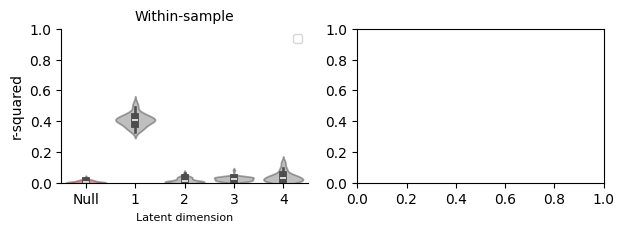

In [ ]:
# Plotting eigenvalues (r2)

# Create a figure and axes
fig = plt.figure(figsize=(7,2))
xlabs = ['Null']
for ii in range(1,latentDim+1):
  xlabs.append(str(ii))

#################################################
################# Within-sample #################
#################################################
# Create a list of jittered data samples
ax = plt.subplot(1,2,1)

# Plot the null model
sns.violinplot(x = 0*np.ones_like(r2_train_null[0,:,:].flatten()), y = r2_train_null[0,:,:].flatten(), color = 'red', fill = True, alpha = 0.5)

# Plot the data samples
temp = r2_train.reshape(-1, r2_train.shape[1]*r2_train.shape[2]).T
for ii in range(latentDim):
  x_r2 = r2_train[ii,:,:].flatten()
  #plt.plot((ii+1)*np.ones_like(x_r2)+ np.random.normal(scale=0.05, size = np.shape(x_r2)), x_r2 , '.', color='gray', alpha=0.2, markersize = 2)
  sns.violinplot(x = (ii+1)*np.ones_like(temp[:,ii]), y = temp[:,ii], color = 'gray', fill = True, alpha = 0.5)
  #plt.boxplot(r2_train.reshape(-1, r2_train.shape[1]*r2_train.shape[2]).T , widths=0.5, boxprops=dict(color='black'),
  #medianprops=dict(color='black'), patch_artist=False)

# Plot null model ################
# Median and 95% CI
#plt.axhline(r2_train_null_median, color = 'red', label = 'Null median')

#plt.axhspan(ymin=r2_train_null[0], ymax=r2_train_null[1], alpha=0.15, color='red', label = 'Null 95% CI')
plt.title('Within-sample', fontsize = 10)
plt.xlabel('Latent dimension', fontsize = 8)
plt.ylabel('r-squared')
plt.ylim([0,1])
plt.legend(fontsize = 8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(len(xlabs)), labels = xlabs)

#################################################
################# Out-of-sample #################
#################################################
ax = plt.subplot(1,2,2)
"""
# Plot the null model
sns.violinplot(x = 0*np.ones_like(r2_test_null[0,:,:].flatten()), y = r2_test_null[0,:,:].flatten(), color = 'red', fill = True, alpha = 0.5)

# Plot the data samples
temp = r2_test.reshape(-1, r2_test.shape[1]*r2_test.shape[2]).T

for ii in range(latentDim):
  x_r2 = r2_test[ii,:,:].flatten()
  #plt.plot((ii+1)*np.ones_like(x_r2)+ np.random.normal(scale=0.05, size = np.shape(x_r2)), x_r2 , '.', color='gray', alpha=0.2, markersize = 2)
  sns.violinplot(x = (ii+1)*np.ones_like(temp[:,ii]), y = temp[:,ii], color = 'gray', fill = True, alpha = 0.5)
  #plt.boxplot(r2_test.reshape(-1, r2_test.shape[1]*r2_test.shape[2]).T , widths=0.5, boxprops=dict(color='black'),
  #medianprops=dict(color='black'), patch_artist=False)

# Plot null model ################
# Median and 95% CI

plt.axhline(r2_test_null_median, color = 'red', label = 'Null median')
plt.axhspan(ymin=r2_test_null_CI95[0], ymax=r2_test_null_CI95[1], alpha=0.15, color='red', label = 'Null 95% CI')
plt.title('Out-of-sample', fontsize = 10)
plt.xlabel('Latent dimension', fontsize = 8)
plt.ylabel('r-squared')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.suptitle('Euclidean (dis)similarity')
plt.xticks(np.arange(len(xlabs)), labels = xlabs)
plt.ylim([0,1])
plt.tight_layout()
figures.append(fig)
plt.show()
"""

[[1.        ]
 [0.345943  ]
 [0.09198431]
 [0.1734626 ]] [[ 0.98816303]
 [ 0.30684404]
 [-0.01468203]
 [ 0.05069214]
 [ 0.67299553]
 [-0.0664547 ]
 [-0.03556889]
 [ 0.03913535]]
RMSE: 1.0372635562296453
R²: 0.3663276719358842


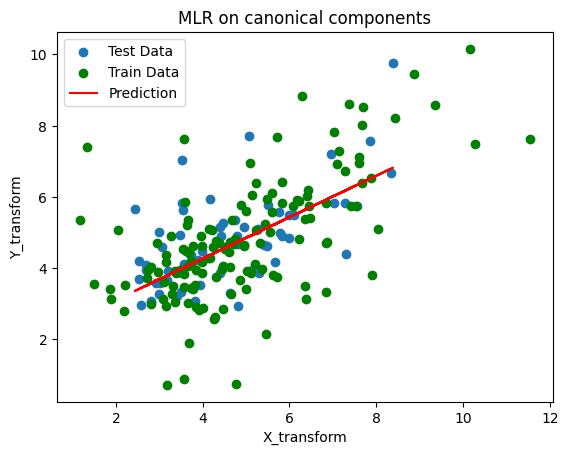

-10496.028164769214


In [ ]:
#MLR implementation

from sklearn.metrics import mean_squared_error
latentDim = 1
##print("Dimensions of X:", X.shape) X:(204,4) = 204 data points & 4 variables in X
##print("Dimensions of Y:", Y.shape) Y:(204,8) = 204 data points & 8 outputs in Y


lr = LinearRegression()
mdl = czoo.rCCA(latent_dimensions = latentDim,  c=1)
mdl.fit((X, Y))
U,V = mdl.transform((X,Y))

##print("Dimensions of U:", U.shape) U is a latent space representation of X or Y with 1 dimension
##print("Dimensions of V:", V.shape) ""

# A contains the weights for features in the cononical components
# B is an aray of intercepts
A, B = mdl.loadings_((X.to_numpy(), Y.to_numpy()))
print(A, B)


#Train-test split for linear regression
U_train, U_test, V_train, V_test = train_test_split(U, V, test_size = 0.3,random_state = 0)
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size = 0.3,random_state = 0)
lr.fit(U_train, V_train)
V_pred = lr.predict(U_test)


#metrics: RMSE & R2 score
mse = mean_squared_error(V_test, V_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse) # indicates how far the predictions are from the actual values
r2 = r2_score(V_test, V_pred)
print("R²:", r2) #suggests that the model explains 36.6% of the variance in the target variable.

#Plot
plt.scatter(U_test, V_test, label = 'Test Data')
plt.scatter(U_train, V_train, color="green", label = 'Train Data' )
plt.plot(U_test, V_pred, color ="red", label ='Prediction')


#print(V_test.shape, V_pred.shape)


plt.xlabel("X_transform")
plt.ylabel("Y_transform")
plt.title("MLR on canonical components")
plt.legend()
plt.show()
#Convert V_hat back into Y
#B_inv = np.linalg.pinv(B)

#Predicting Back to Original Space

#Y_pred = np.dot(V_pred, np.transpose(B))

#07/02 - diff way to predict Y-pred, results a somewhat smaller negative number??
B_inv = np.linalg.pinv(B)
Y_pred = np.dot(V_pred, B_inv)


#print(Y_pred)
#print(Y_test)
#r2 for Y
print(r2_score(Y_test, Y_pred))

In [ ]:
# Coefficient plots
mdl = czoo.rCCA(latent_dimensions = latentDim,  c=[c_1,c_2])

# Fit the full model on all data
X = df.iloc[:, 43:47]
Y = df.iloc[:, 79:87]
mdl = mdl.fit( (X, Y) )
fullModel_r2 = np.square(mdl.average_pairwise_correlations( (X, Y) ) ) # r2 on all data
fullModel_A, fullModel_B = mdl.loadings_( (X, Y) )
fullModel_U, fullModel_V = mdl.transform( (X, Y) )
# Plot model coefficients
fig = plt.figure(figsize=(8,7))
numDims = 4
for jj in range(numDims):
  ax = plt.subplot(numDims,2,jj*2+1)
  # PC matrix
  im = plt.bar(np.arange(0, np.shape(rms_array)[1]), fullModel_A[:,jj], color='gray', label = 'median and 95% CI')
  plt.axhline(0, color = 'black', linewidth = .5)
  if jj == 0:
    plt.title('A',fontsize = 10, weight = 'bold')
  if jj < numDims-1:
    plt.xticks([])
  else:
    plt.xticks(np.arange(0, np.shape(rms_array)[1]), labels=rms_labels, rotation=90)
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  # Discrete variable matrix
  ax = plt.subplot(numDims,2,jj*2+2)
  im = plt.bar(np.arange(0, np.shape(clin_array)[1]), fullModel_B[:,jj], color='gray')
  plt.axhline(0, color = 'black', linewidth = .5)
  if jj == 0:
    plt.title('B',fontsize = 10, weight = 'bold')
  if jj < numDims-1:
    plt.xticks([])
  else:
    plt.xticks(np.arange(0, np.shape(clin_array)[1]), labels=clin_labels, rotation=90)
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  fig.text(0.5, 0.9-jj*.05*numDims, 'Latent dimension ' + str(jj+1) + ' | r2 = ' + str(np.round(fullModel_r2[jj],2)), ha='center', fontsize = 10, weight = 'bold')
fig.subplots_adjust(wspace=.5)
fig.subplots_adjust(hspace=.5)
fig.suptitle('Full model (null r2 = ' + str(np.round(r2_test_null_median,2)) + ')' )
#plt.ylabel('Canonical coefficient', fontsize = 10)
#plt.title('Latent dimension 1',fontsize = 10, weight = 'bold')
fig.text(0.01, 0.5, 'Canonical coefficient', ha='center', rotation = 'vertical', fontsize = 10)
#fig.text(0.5, 0.6, 'Latent dimension 2', ha='center', fontsize = 10, weight = 'bold')
# Save
#plt.tight_layout()
figures.append(fig)
plt.show()
ax.legend(loc='center', bbox_to_anchor=(-.25, 1.25), labels=('YA','OA','MCI'), fontsize=8)
fig = plt.gcf()
fig.set_size_inches(2.5,2)
# Save
figures.append(fig)
plt.show()

NameError: name 'c_1' is not defined